In [3]:
INPUT_SHAPE = (224,224)
BATCH_SIZE = 32
train_path='../input/plantvillage-dataset/color/'

In [4]:
!pip install tensorflow_addons

## Plotting Libaray
import matplotlib.pyplot as plt
import seaborn as sns
## Pandas Dataframe Library
import pandas as pd
## Numpy Library
import numpy as np
## Train and Test Split
from sklearn.model_selection import train_test_split
## Evaluation Matrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Libray to convert text to integer
from sklearn.preprocessing import OneHotEncoder
## OpenCV libraries
import os
import cv2
## Normalize
from sklearn.preprocessing import StandardScaler
## Model
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
## ImageGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import glob, warnings

In [5]:
data_gen_train = ImageDataGenerator(rescale = 1/255.0,featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
         validation_split=0.3)
data_gen_test = ImageDataGenerator(rescale = 1/255.0)

In [6]:
X_train = data_gen_train.flow_from_directory(train_path,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=INPUT_SHAPE,subset='training')

X_test = data_gen_train.flow_from_directory(train_path,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=INPUT_SHAPE,subset='validation')

Found 38029 images belonging to 38 classes.
Found 16276 images belonging to 38 classes.


In [7]:
IMAGE_SIZE = 224

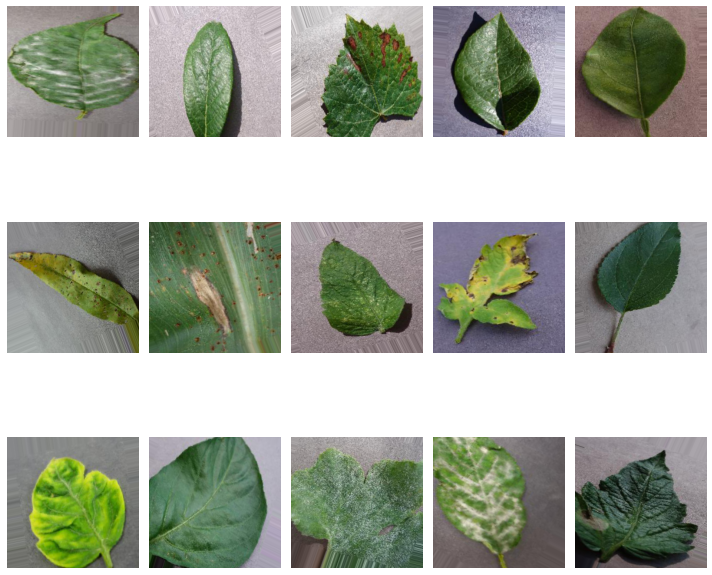

In [8]:
images = [X_train[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
!pip install vit-keras

In [10]:
from vit_keras import vit

In [11]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 38)

2023-02-16 10:40:52.879861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 10:40:52.889669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 10:40:52.890437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 10:40:52.892280: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(50, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(38, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 50)                38450     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1938      
Total params: 87,498,892
Trainable params: 87,497,256
Non-trainable params: 1,636
________________________________

In [13]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = X_train.n // X_train.batch_size
STEP_SIZE_VALID = X_test.n // X_test.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

In [26]:
callbacks = [earlystopping, reduce_lr, checkpointer]

history = model.fit(x = X_train,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = X_test,
          validation_steps = STEP_SIZE_VALID,
          epochs = 10,
          callbacks = callbacks)

Epoch 1/10
1188/1188 [==============================] - 989s 833ms/step - loss: 1.8811 - accuracy: 0.8070 - val_loss: 1.6241 - val_accuracy: 0.8928

Epoch 00001: val_accuracy improved from 0.80000 to 0.89278, saving model to ./model.hdf5
Epoch 2/10
1188/1188 [==============================] - 831s 699ms/step - loss: 1.6425 - accuracy: 0.9021 - val_loss: 1.4721 - val_accuracy: 0.9438

Epoch 00002: val_accuracy improved from 0.89278 to 0.94384, saving model to ./model.hdf5
Epoch 3/10
1188/1188 [==============================] - 829s 698ms/step - loss: 1.4997 - accuracy: 0.9473 - val_loss: 1.3955 - val_accuracy: 0.9650

Epoch 00003: val_accuracy improved from 0.94384 to 0.96500, saving model to ./model.hdf5
Epoch 4/10
1188/1188 [==============================] - 819s 689ms/step - loss: 1.4187 - accuracy: 0.9672 - val_loss: 1.3551 - val_accuracy: 0.9755

Epoch 00004: val_accuracy improved from 0.96500 to 0.97552, saving model to ./model.hdf5
Epoch 5/10
1188/1188 [==========================

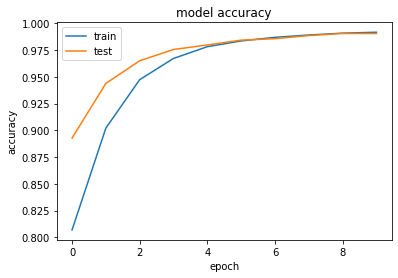

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

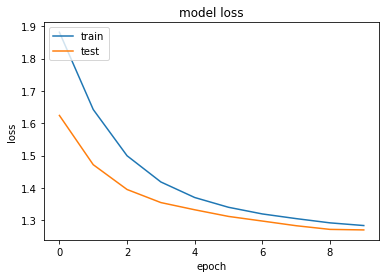

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
model.save('./model.h5')

In [37]:
import os
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
    
FileLink(r'model.h5')

/kaggle/working/model.h5

In [38]:
## Prediction
testimages,true_labels = next(X_test)
predictions = model.predict(testimages)

# Get most likely class
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))

In [39]:
# Get most likely class
true_labels = np.array(list(map(lambda x: np.argmax(x), true_labels)))
class_labels = list(X_train.class_indices.keys())   

In [46]:
from sklearn.metrics import accuracy_score
print("Accuracy Of Model = ",accuracy_score(true_labels, predictions)*100,'%')


Accuracy Of Model =  96.875 %
